<a href="https://colab.research.google.com/github/KhNick/laba/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22lab_work%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа

Баллы за секции:
- *Задание 1* - 10 баллов
- *Задание 2* - 20 баллов
- *Задание 3* - 30 баллов
- **Итого** - 60 баллов

Оценка за лабу $ = \frac{score}{6}$

## Внимание! Attention!\: Achtung!

**Данная лабораторная работа является блокирующей**, т.е. если лабораторная работа не выполнена, то оценка за курс - неуд.

Лабораторная работа считается выполненной, если **за каждое из заданий получено не менее 2 баллов**.

## Формат сдачи лабораторной работы

Данная лабораторная работа сдается так же, как и проект - заполняете данный ноутбук, отправляете его через GitHub с указанием проверяющего.

**Ассистенты не будут запускать ячейки кода, а смотреть на выведенный результат и код. Если ячейка кода не запущена - балл не ставится, даже при правильно написанном коде.**

***(Комментарии что курс по Python легче чем по C++ учтены)***

>**Примечание**
>
>Данные задания вдохновлены предметом "Введение в анализ данных" 2 курса, по итогу которого идёт отбор на DS-поток. Если вы видите себя в смежных областях, советуем выполнить данную лабораторку по максимуму.

In [36]:
# Всё необходимое для выполнения данной лабораторной работы!
import requests
from time import sleep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Задание 1. Парсинг - 10 баллов

В этом задании Вам предстоит работать с API сайта <a target="_blank" href="hh.ru">hh.ru</a>. Документация доступна по <a target="_blank" href="https://github.com/hhru/api/blob/master/docs/vacancies.md#search">ссылке</a>.

<b><font color="red">Внимание!</font> При работе с API не забывайте делать паузы между запросами, иначе вас забанят. Просрочка дедлайна по этой причине не принимается!</b>

**Задача:**
1. выбрать 5 интересующих вас профессий (не смежных, т.е. Аналатик и Data Engineer не считается корректным)
2. затем получить доступные по данным профессиям вакансии в Москве и выделить их физические координаты
3. нанести полученные координаты на карту местоположения компаний

*Пример запроса для профессии:*

In [37]:
URL = 'https://api.hh.ru/vacancies'

params = {
    'text': "Физик-ядерщик",
    'area': 1,
    'page': 0,
    'per_page': 10
}

data = requests.get(URL, params).json()

Если Ваш запрос прошел успешно, то вы получите следующие ключи (значения данных ключей вы найдете по ссылке на документацию):

In [38]:
data.keys()

dict_keys(['items', 'found', 'pages', 'page', 'per_page', 'clusters', 'arguments', 'fixes', 'suggests', 'alternate_url'])

>**Примечание**
>
>В `data['pages']` будет хранится количество найденных страниц вакансий - для корректного сбора данных Вам нужно пробежать по **КАЖДОЙ** странице и сделать соотвествующие запросы.

>**Совет**
>
>Посмотрите что хранится в `items`!

(1 балл) Выберете для нас 5 наиболее интересных специальностей и получите по ним имеющиеся вакансии:

In [43]:
jobs = ['c++ разработчик', 'Агент по недвижимости', 'учитель математики', 'библиотекарь', 'Секретарь, помощник руководителя, ассистент']
URL = 'https://api.hh.ru/vacancies'
data = [requests.get(URL, { 'text': job, 'area': 1, 'per_page': 100 }).json() for job in jobs]
columns = ['job', 'name', 'employer', 'lat', 'lng']
df = pd.DataFrame(columns=columns)
for index, job in enumerate(jobs):
  for page in range(data[index]['pages']):
    vacancies = requests.get(URL,
     { 'text': job, 'area': 1, 'per_page': 100, 'page': page }
                             ).json()['items']
    sleep(1)
    for vacancy in vacancies:
      description = [job,
                     vacancy['name'],
                     vacancy['employer']['name'],
                     vacancy.get('address', np.nan).get('lat', np.nan) if vacancy['address'] != None else np.nan,
                     vacancy.get('address', np.nan).get('lng', np.nan) if vacancy['address'] != None else np.nan]
      df = pd.concat([df, pd.DataFrame(columns=columns,
                                      data = [description])],
                     ignore_index=True)


(1 балл) Посчитайте сколько всего найдено вакансий:

In [45]:
len(df)


3346

(1 балл) Создайте структуру данных, которая будет хранить в себе имя компании и ее координаты (широта и долгота):

In [ ]:
class Company:
    def __init__(self, name = None, latitude = None, longitude = None):
      self.name = name
      self.latitude = latitude
      self.longitude = longitude
    def __str__(self):
      return self.name + " " + str(self.latitude) + " " + str(self.longitude)

(1 балл) Создайте экземпляр этой структуры данных для каждой компании, которая выставила вакансию:

In [41]:
df2 = df
df2["company"] = Company(df["employer"], df['lat'], df['lng'])

companies = df['company'].unique()

(1 балл) Найдите количество вакансий, у которых заданы координаты (значения данных может быть пустым):

In [46]:
len(df[df["lat"].notna()])


2242

(1 балл) Отберите вакансии, которые расположены в пределах МКАД (можно грубо):

In [47]:
mkad_km =  pd.DataFrame(columns=['km', 'lng', 'lat'], data=[
[1,37.842762,55.774558],
[2,37.842789,55.76522],
[3,37.842627,55.755723],
[4,37.841828,55.747399],
[5,37.841217,55.739103],
[6,37.840175,55.730482],
[7,37.83916,55.721939],
[8,37.837121,55.712203],
[9,37.83262,55.703048],
[10,37.829512,55.694287],
[11,37.831353,55.68529],
[12,37.834605,55.675945],
[13,37.837597,55.667752],
[14,37.839348,55.658667],
[15,37.833842,55.650053],
[16,37.824787,55.643713],
[17,37.814564,55.637347],
[18,37.802473,55.62913],
[19,37.794235,55.623758],
[20,37.781928,55.617713],
[21,37.771139,55.611755],
[22,37.758725,55.604956],
[23,37.747945,55.599677],
[24,37.734785,55.594143],
[25,37.723062,55.589234],
[26,37.709425,55.583983],
[27,37.696256,55.578834],
[28,37.683167,55.574019],
[29,37.668911,55.571999],
[30,37.647765,55.573093],
[31,37.633419,55.573928],
[32,37.616719,55.574732],
[33,37.60107,55.575816],
[34,37.586536,55.5778],
[35,37.571938,55.581271],
[36,37.555732,55.585143],
[37,37.545132,55.587509],
[38,37.526366,55.5922],
[39,37.516108,55.594728],
[40,37.502274,55.60249],
[41,37.49391,55.609685],
[42,37.484846,55.617424],
[43,37.474668,55.625801],
[44,37.469925,55.630207],
[45,37.456864,55.641041],
[46,37.448195,55.648794],
[47,37.441125,55.654675],
[48,37.434424,55.660424],
[49,37.42598,55.670701],
[50,37.418712,55.67994],
[51,37.414868,55.686873],
[52,37.407528,55.695697],
[53,37.397952,55.702805],
[54,37.388969,55.709657],
[55,37.383283,55.718273],
[56,37.378369,55.728581],
[57,37.374991,55.735201],
[58,37.370248,55.744789],
[59,37.369188,55.75435],
[60,37.369053,55.762936],
[61,37.369619,55.771444],
[62,37.369853,55.779722],
[63,37.372943,55.789542],
[64,37.379824,55.79723],
[65,37.386876,55.805796],
[66,37.390397,55.814629],
[67,37.393236,55.823606],
[68,37.395275,55.83251],
[69,37.394709,55.840376],
[70,37.393056,55.850141],
[71,37.397314,55.858801],
[72,37.405588,55.867051],
[73,37.416601,55.872703],
[74,37.429429,55.877041],
[75,37.443596,55.881091],
[76,37.459065,55.882828],
[77,37.473096,55.884625],
[78,37.48861,55.888897],
[79,37.5016,55.894232],
[80,37.513206,55.899578],
[81,37.527597,55.90526],
[82,37.543443,55.907687],
[83,37.559577,55.909388],
[84,37.575531,55.910907],
[85,37.590344,55.909257],
[86,37.604637,55.905472],
[87,37.619603,55.901637],
[88,37.635961,55.898533],
[89,37.647648,55.896973],
[90,37.667878,55.895449],
[91,37.681721,55.894868],
[92,37.698807,55.893884],
[93,37.712363,55.889094],
[94,37.723636,55.883555],
[95,37.735791,55.877501],
[96,37.741261,55.874698],
[97,37.764519,55.862464],
[98,37.765992,55.861979],
[99,37.788216,55.850257],
[100,37.788522,55.850383],
[101,37.800586,55.844167],
[102,37.822819,55.832707],
[103,37.829754,55.828789],
[104,37.837148,55.821072],
[105,37.838926,55.811599],
[106,37.840004,55.802781],
[107,37.840965,55.793991],
[108,37.841576,55.785017]
])
mkad_km.describe()
comp_with_cord = df[df["lat"].notna()]
within_mkad = comp_with_cord[(comp_with_cord['lat'] >= mkad_km['lat'].min()) &
                                      (comp_with_cord['lat'] <= mkad_km['lat'].max()) &
                                      (comp_with_cord['lng'] >= mkad_km['lng'].min()) &
                                      (comp_with_cord['lng'] <= mkad_km['lng'].max())]
within_mkad

,job,name,employer,lat,lng
0,c++ разработчик,Начинающий (Junior) Программист/Стажер,Ай-Технолоджис Групп,55.579012,37.605724
1,c++ разработчик,Стажер-Разработчик,"Держава , АКБ",55.736518,37.569935
3,c++ разработчик,QA enginner Middle/ инженер тестировщик,Интелком Лайн,55.731830,37.546156
4,c++ разработчик,Junior программист/разработчик Frontend backen...,AVPOWER,55.809398,37.507107
5,c++ разработчик,Middle+ QA Engineer,Xello,55.749618,37.537371
...,...,...,...,...,...
3339,"Секретарь, помощник руководителя, ассистент",Секретарь,Биос,55.786485,37.661159
3340,"Секретарь, помощник руководителя, ассистент","Помощник руководителя, секретарь, офис-менеджер",КСЕ-тех,55.751148,37.655248
3341,"Секретарь, помощник руководителя, ассистент",Юрист,ШоуКрафт,55.806525,37.584964
3342,"Секретарь, помощник руководителя, ассистент",Офис-менеджер,Comelit,55.776375,37.690228


(1 балл) Постройте график в координатах "широта-долгота" для отображения вакансий внутри МКАД (не забывайте прописать прозрачность, чтобы увидеть скопления):

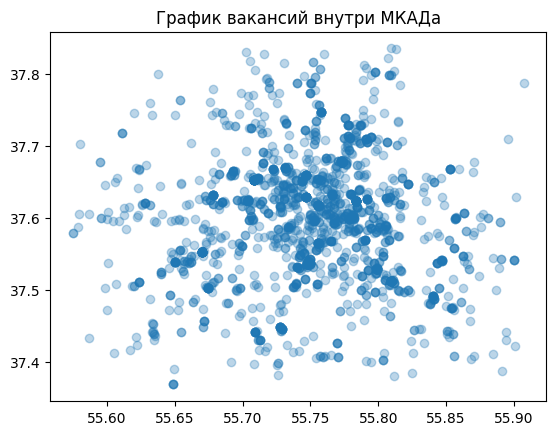

In [53]:
plt.scatter(x=within_mkad['lat'], y=within_mkad["lng"], alpha = 0.3)
plt.title("График вакансий внутри МКАДа")
# plt.xlabel('вес')
# plt.ylabel('стоимость')
plt.show()

(1 балл) Нанесите все точки вакансий на карту (для этого вам поможет данная <a target="_blank" href="https://plotly.com/python/mapbox-layers/">документации</a>, не забудьте про прозрачность и центрирование по Москве):

In [62]:
import plotly.express as px
fig = px.scatter_mapbox(within_mkad, lat="lat", lon="lng",
                        color_discrete_sequence=["fuchsia"], zoom=10, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

(2 балла) **Сделайте выводы о проделанной работе:**

>*Подсказки для маленьких: Что вы можете сказать про районы Москвы? Что вы можете сказать про зарплаты? Что вы можете сказать про спрос?*

Как видно из полученных данных, практически все вакансии, имеющие координаты, расположены внутри МКАДа, оно и логично, туда проще добраться. Более того распределение вакансий имеет плотность, увеличивающуюся к центру, показывая более высокий спрос в сердце города.

## Задание 2. Анализ данных - 20 баллов

Вам предстоит проанализировать датасет, содержащий информацию об бриллианта, их стоимости и остальных характеристиках.



Поясним значения хранящиеся в колонках:
*   `cut` - огранка бриллианта (относится к одной из примерно 10 наиболее распространенных)
*   `color` - цвет бриллианта, прозрачные бриллианты имеют градацию `D-Z`, "более высокие" буквы - более желтоватые, но часто имеют лучшие значения, поскольку цвет трудно определить один раз в кольце
*   `clarity` - чистота бриллианта, наличие включений (внутренних дефектов), чем меньше и мельче, тем лучше
*   `carat_weight` - масса бриллианта (слабо связана с размером бриллианта, т.к. огранка и качество огранки, как правило, играют большую роль)
*   `cut_quality` - качество ограники по системе оценки GIA Cut
*   `lab` - лаборатория оценивания
*   `meas_length` - длина бриллианта
*   `meas_width` - ширина бриллианта
*   `meas_depth` - глубина бриллианта
*   `total_sales_price` - цена бриллианта в долларах.
*    **и прочие колонки**

Скачаем данные:

In [64]:
!gdown 10OJ30qlkE-7zK4JuVTDMY3U4nRB4tu_8

Downloading...
From: https://drive.google.com/uc?id=10OJ30qlkE-7zK4JuVTDMY3U4nRB4tu_8
To: /content/diamonds.csv
100% 35.4M/35.4M [00:00<00:00, 50.1MB/s]


Создадим DataFrame:

In [65]:
import pandas as pd

diamonds = pd.read_csv("diamonds.csv")
diamonds

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,NaN,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,...,8.66,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,1210692
219699,219700,Radiant,unknown,VS2,5.17,unknown,GIA,Very Good,Very Good,unknown,...,5.71,TK,XTK,unknown,NaN,Green,unknown,NaN,Fancy Light,1292500
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,...,10.20,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,1315496
219701,219702,Princess,unknown,SI2,0.90,unknown,GIA,Good,Good,unknown,...,3.47,XTN,VTK,unknown,Faint,Red,unknown,unknown,Fancy,1350000


(0.5 балла) Выведете первые 5 строк датасета:

In [66]:
diamonds.head(5)

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,NaN,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200


(0.5 балла) Найдите количество бриллиантов всего в данном датасете:

In [67]:
len(diamonds)

219703

(0.5 балла) Выведите максимальную и минимальную цену бриллианта в формате `номер - цена`:

In [68]:
costs = diamonds['total_sales_price']
print(costs.idxmin(),"-", costs.min())
print(costs.idxmax(),"-", costs.max())

0 - 200
219702 - 1449881


(1 балл) Посчитайте количество пропусков (пропуском считается значение `unknown` или `None`):

In [69]:
diamonds.replace("unknown", None).isnull().sum().sum()

1891168

(1 балл) Найдите в каких столбцах присутствуют пропуски:

In [70]:
for i in list(diamonds):
  if len(diamonds[diamonds[i].isin(["unknown", None])]) != 0:
    print(i)

color
cut_quality
eye_clean
culet_size
culet_condition
girdle_min
girdle_max
fluor_color
fluor_intensity
fancy_color_dominant_color
fancy_color_secondary_color
fancy_color_overtone
fancy_color_intensity


В нашем датасете присутствуют колонки, которые начинаются с `fancy_color_` или `fluor_`. Большинство значений в этих колонках - `unknown` или `None`, поэтому мы считаем их малоинформативными.

Ваша задача:

1. (0.5 балла) найти количество таких колонок, которые начинаются с `fancy_color_` или `fluor_`:

In [71]:
s = 0
for i in list(diamonds):
  if i.startswith("fancy_color_") or i.startswith("fluor_"):
    s+=1
s

6

2. (0.5 балла) найти количество информативных (не `None` или `unknown`) значений в этих колонках:

In [72]:
names = [i for i in list(diamonds) if i.startswith('fancy_color_') or i.startswith('fluor_')]
len(diamonds[names]) * len(names) - diamonds[names].replace("unknown", None).isnull().sum().sum()

111586

3. (0.5 балла) удалить данные колонки из датасета, сохранив изменения (в дальнейшем работаем измененным датасетом):

In [73]:
diamonds = diamonds[[col for col in list(diamonds) if col not in names]]

(1 балл) Проделайте тоже самое для колонок, начинающихся с `culet_`:

In [74]:
diamonds = diamonds[[col for col in list(diamonds) if not col.startswith("culet_")]]

(1 балл) Посчитайте сколько бы стоил (в тысячах долларов) сейф, в котором хранились бы все бриллианты из датасета:

In [75]:
diamonds["total_sales_price"].sum() / 1000

1517721.991

Немного необоснованных манипуляций.

(1 балл) Выберите из датасета строки с четными индексами и выведете значения (не меняя нумерацию индексов):

In [76]:
diamonds[diamonds['Unnamed: 0'] % 2 == 0]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.1,59.0,2.88,2.90,1.77,TN,M,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,64.9,58.5,2.79,2.83,1.82,STK,STK,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
8,8,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,63.5,59.5,2.89,2.92,1.85,STK,TK,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219693,219694,Round,E,IF,12.52,Excellent,GIA,Excellent,Excellent,unknown,62.1,58.0,14.84,14.91,9.24,unknown,unknown,1121792
219695,219696,Cushion Modified,unknown,VVS1,10.00,unknown,GIA,Very Good,Excellent,unknown,78.1,60.0,11.78,10.84,8.47,unknown,unknown,1124122
219697,219698,Oval,unknown,VS1,10.04,unknown,GIA,Excellent,Excellent,unknown,72.8,55.0,14.13,10.86,7.90,unknown,unknown,1161102
219699,219700,Radiant,unknown,VS2,5.17,unknown,GIA,Very Good,Very Good,unknown,64.8,65.0,11.55,8.81,5.71,TK,XTK,1292500


(0.5 балла) А теперь с индексами, кратными 6:

In [77]:
diamonds[::6]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
12,12,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,61.8,58.5,2.85,2.89,1.77,STK,TK,200
18,18,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.0,60.0,2.91,2.92,1.78,M,M,200
24,24,Round,L,I1,0.34,Excellent,IGI,Excellent,Excellent,unknown,0.0,0.0,0.00,0.00,0.00,unknown,unknown,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219678,219679,Round,G,VS1,10.23,Excellent,GIA,Excellent,Excellent,unknown,62.7,55.0,13.82,13.92,8.69,TN,M,859320
219684,219685,Radiant,unknown,I1,0.89,unknown,GIA,Good,Good,unknown,63.8,57.0,6.44,4.96,3.16,TK,VTK,982560
219690,219691,Round,D,VVS2,10.10,Excellent,GIA,Excellent,Excellent,unknown,59.4,59.0,14.07,14.15,8.39,M,STK,1040739
219696,219697,Oval,H,VS2,18.88,unknown,GIA,Excellent,Excellent,unknown,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347


(1 балл) Выберете из датасета только категорильные признаки и выведете датасет:

In [78]:
diamonds.info()
diamonds.select_dtypes('object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219703 entries, 0 to 219702
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         219703 non-null  int64  
 1   cut                219703 non-null  object 
 2   color              219703 non-null  object 
 3   clarity            219703 non-null  object 
 4   carat_weight       219703 non-null  float64
 5   cut_quality        219703 non-null  object 
 6   lab                219703 non-null  object 
 7   symmetry           219703 non-null  object 
 8   polish             219703 non-null  object 
 9   eye_clean          219703 non-null  object 
 10  depth_percent      219703 non-null  float64
 11  table_percent      219703 non-null  float64
 12  meas_length        219703 non-null  float64
 13  meas_width         219703 non-null  float64
 14  meas_depth         219703 non-null  float64
 15  girdle_min         219703 non-null  object 
 16  gi

,cut,color,clarity,cut_quality,lab,symmetry,polish,eye_clean,girdle_min,girdle_max
0,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,M,M
1,Round,E,VVS2,Very Good,IGI,Very Good,Very Good,unknown,STK,STK
2,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,TN,M
3,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,M,STK
4,Round,E,VVS2,Very Good,IGI,Very Good,Excellent,unknown,STK,STK
...,...,...,...,...,...,...,...,...,...,...
219698,Round,E,VS1,Excellent,GIA,Excellent,Excellent,unknown,M,STK
219699,Radiant,unknown,VS2,unknown,GIA,Very Good,Very Good,unknown,TK,XTK
219700,Round,E,VS1,Excellent,GIA,Excellent,Excellent,unknown,TN,M
219701,Princess,unknown,SI2,unknown,GIA,Good,Good,unknown,XTN,VTK


>**Примечание**
>
>Данный датасет можно использовать для задания 3 (с использованием `sklearn`)

(0.5 балла) Выберете столбец с данными о цене бриллиантов и домножите его на тот столбец, только транспонированный, и выведите полученную матрицу:

In [79]:
col_cost = diamonds["total_sales_price"] @ diamonds["total_sales_price"].T
col_cost

158540672665477

### Построение графиков

**Требования к графику:**

1.   График должен быть подписан
2.   Оси должны быть подписаны
3.   Должна быть легенда графика
4.   График должен быть информативным (желательно без сильных выбросов)

**Все надписи на русском языке!**

>**Примечание**
>
>График необходимо строить для очищенных данных - в них не должно быть пропусков по осям, по которым строите график. При этом **не перезатирайте** имеющийся датафрейм!

(2 балла) Постройте график `цвет бриллианта - стоимость`:

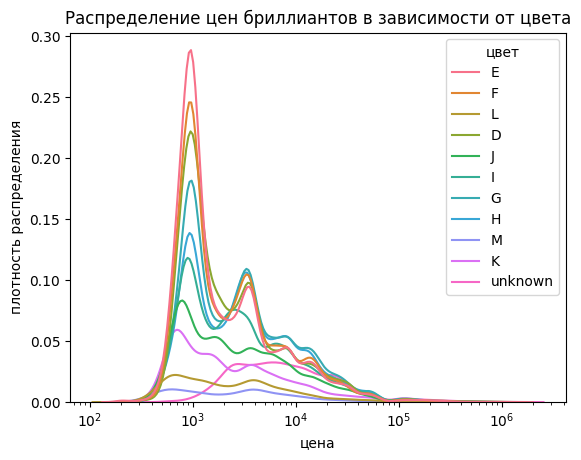

In [80]:
data = diamonds
data["цвет"] = data["color"]
sns.kdeplot(data, x = "total_sales_price", hue = "цвет", log_scale = True)
plt.title( label="Распределение цен бриллиантов в зависимости от цвета")
plt.xlabel("цена")
plt.ylabel("плотность распределения")
# plt.legend(title = "цвет", labels = diamonds["color"])
plt.show()

(2 балла) Постройте график `лабораторная оценка - кол-во бриллиантов`:

<ipython-input-81-3ecb4a97be38>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-81-3ecb4a97be38>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



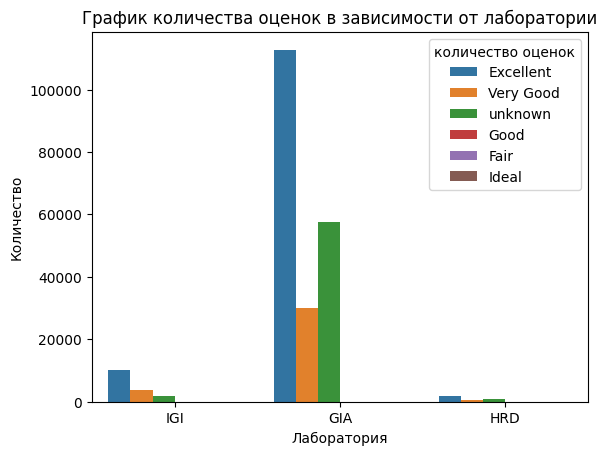

In [81]:
df=diamonds[['lab']]
df["количество оценок"] = diamonds['cut_quality']
df["Value"] = 1
sns.barplot(data=df, x='lab', y='Value', hue='количество оценок', estimator=sum)

# Add labels and title
plt.xlabel('Лаборатория')
plt.ylabel('Количество')
plt.title('График количества оценок в зависимости от лаборатории')

# Show the plot
plt.show()

(2 балла) Постройте график `вес бриллианта - стоимость`:

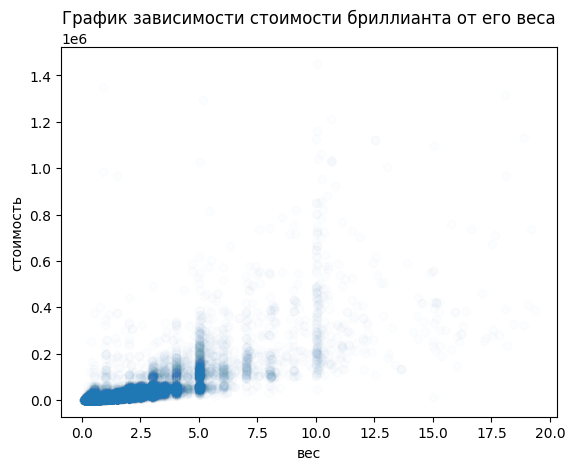

In [82]:
plt.scatter(x=diamonds['carat_weight'], y=diamonds["total_sales_price"], alpha = 0.01)
plt.title("График зависимости стоимости бриллианта от его веса")
plt.xlabel('вес')
plt.ylabel('стоимость')
plt.show()

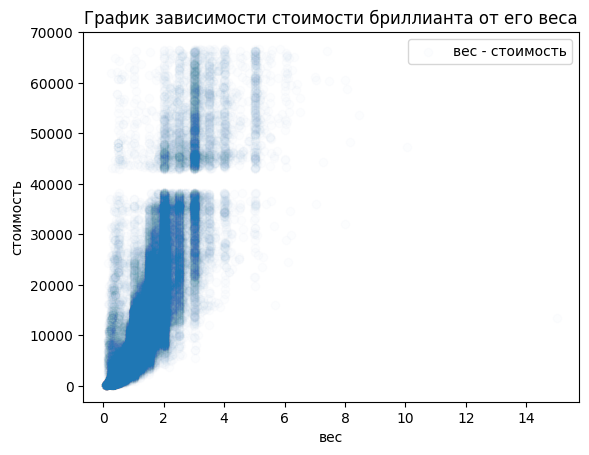

In [83]:
# убираем выбросы
data = diamonds[diamonds["total_sales_price"] <= diamonds["total_sales_price"].max()* 0.06]

plt.scatter(x=data['carat_weight'], y=data["total_sales_price"], alpha = 0.01)
plt.title("График зависимости стоимости бриллианта от его веса")
plt.xlabel('вес')
plt.ylabel('стоимость')
plt.legend(labels=["вес - стоимость"])
plt.show()

(2 балла) Постройте график `система оценки GIA Cut - кол-во бриллиантов`:

In [84]:
diamonds['cut_quality'].value_counts()

cut_quality
Excellent    124861
unknown       60607
Very Good     34201
Good             28
Fair              5
Ideal             1
Name: count, dtype: int64

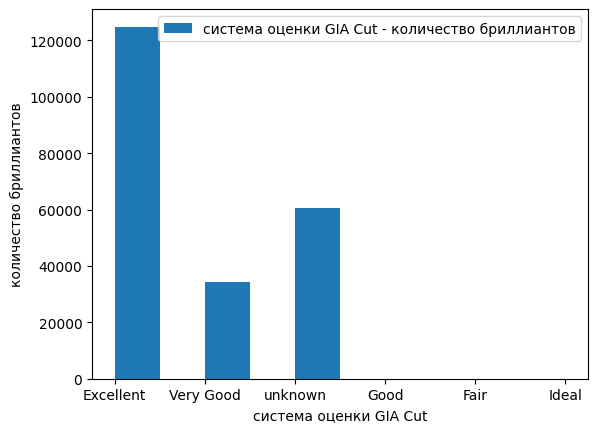

In [85]:
plt.hist(diamonds['cut_quality'], label="система оценки GIA Cut - количество бриллиантов")
plt.xlabel("система оценки GIA Cut")
plt.ylabel("количество бриллиантов")
plt.legend()
plt.show()

(2 балла) **Сделайте выводы по построенным графикам:**

>*Подсказка для маленьких: Что вы можете сказать о графиках полученных выше для данного датасета?*

Первый график, отражающий распределение плотностей цен для разных цветов, демонстрирует очень схожие контуры у большинства цветов, с достаточно большой выборкой, откуда следует вывод, сам цвет на распределение влияет мало. В лабораторной оценке видно, что большую часть оценлк дала одна и та же лаборатория из-за чего использовать этот параметр мало осмысленно. График сравнения веса и стоимости блиллианта, отражает, что большая часть бриллиантов имеет примерно схожие габариты и не большой расброс цен внутри них, в целом напоминающий кусок плоскости ограниченный парой парабол с общей вершиной и горизонтальной прямой сверху. Благодаря нему можно понять что выбросы - все бриллианты с ценой больше 6% от максимальной. Наконец последний график демонстрирует, что все бриллианты находятся всего в 3х категориях оценки, и примерно треть из них -в категории "неизвестно", т.е. это мало чего дающий параметр.


## Задание 3. Модель - 30 баллов

В данном задании вам предстоит построить классифицирующую модель размер алмаза и его стоимости, а затем оценить полученную модель.

>**Примечание**
>
>Данная модель не претендует на самый верный индикатор стоимости алмаза, ведь мы не учитываем ничего больше чем стоимость алмаза. Исключительно для образовательных целей :)

Для построения модели нам понадобится 4 столбца, а именно:
- `meas_length`
- `meas_width`
- `meas_depth`
- `total_sales_price`

От остальных столбцов можно избавиться.

(1 балл) Создайте новый датасет и выведите его первые 10 строк:

In [86]:
df = diamonds[["meas_length", "meas_width", "meas_depth", "total_sales_price"]]
df

,meas_length,meas_width,meas_depth,total_sales_price
0,2.85,2.87,1.79,200
1,2.84,2.89,1.78,200
2,2.88,2.90,1.77,200
3,2.86,2.88,1.78,200
4,2.79,2.83,1.82,200
...,...,...,...,...
219698,14.06,14.18,8.66,1210692
219699,11.55,8.81,5.71,1292500
219700,17.06,17.10,10.20,1315496
219701,5.22,4.90,3.47,1350000


(1 балл) Перемешайте строки в датафрейме случайным образом:

In [87]:
df.sample(frac=1)

,meas_length,meas_width,meas_depth,total_sales_price
14605,4.43,4.46,2.79,684
179875,6.40,6.42,3.97,7484
179833,6.25,6.32,4.05,7470
129772,5.08,5.12,3.21,2856
166615,5.85,5.87,3.64,5658
...,...,...,...,...
180576,6.83,6.87,4.21,8178
137953,7.30,4.79,2.94,3278
94725,4.80,4.82,3.03,1420
150541,5.28,5.30,3.30,3810


(1 балл) Сформируем новую колонку - для каждого бриллианта найдем сумму Минковского (p=3) по 3 измерениям бриллианта:

In [88]:
df["minkowski"] = np.power((np.power(df["meas_length"], 3) + np.power(df["meas_width"], 3) + np.power(df["meas_depth"], 3)), 1/3)
df

<ipython-input-88-11eeab8715b5>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,meas_length,meas_width,meas_depth,total_sales_price,minkowski
0,2.85,2.87,1.79,200,3.745015
1,2.84,2.89,1.78,200,3.748797
2,2.88,2.90,1.77,200,3.775608
3,2.86,2.88,1.78,200,3.754425
4,2.79,2.83,1.82,200,3.694108
...,...,...,...,...,...
219698,14.06,14.18,8.66,1210692,18.449681
219699,11.55,8.81,5.71,1292500,13.408649
219700,17.06,17.10,10.20,1315496,22.257728
219701,5.22,4.90,3.47,1350000,6.706710


(1 балл) Сформируем новый датасет из двух колонок - сумма Минковского и `total_sales_price`:

In [89]:
df_pair = df[["minkowski"]]
df_pair["price"] = df["total_sales_price"]

<ipython-input-89-355114639682>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(1 балл) Разделите вашу выборку на две части в соотношении 8:2 - одна выборка будет для тренировка, а другая для тестов вашей модели:

In [90]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_pair['minkowski'], df_pair['price'], test_size=0.2)

(2 балла) Постройте график зависимости стоимости от вашего нового параметра размера для тренинг-выборки:

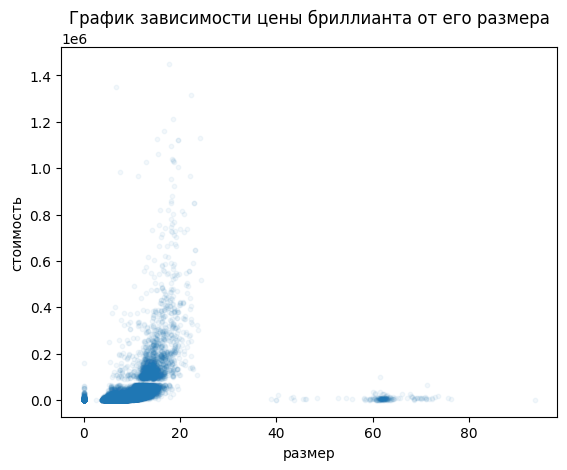

In [91]:
plt.scatter(x_train, y_train, s = 10, alpha = 0.05)
plt.title("График зависимости цены бриллианта от его размера")
plt.xlabel('размер')
plt.ylabel('стоимость')
plt.show()

(2 балла) Нанесите на тот же график тестовую выборку, используя другой цвет (не забудьте про параметр прозрачности):

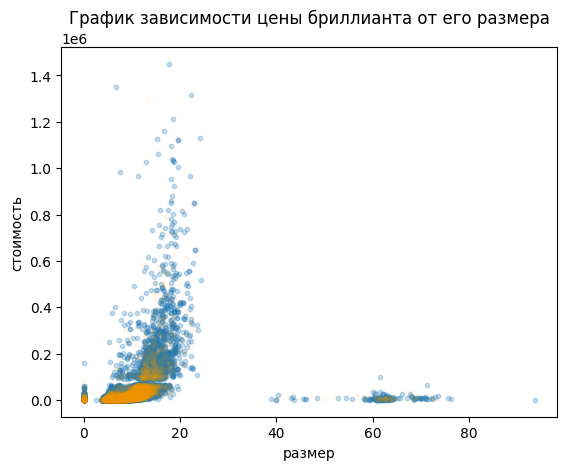

In [92]:
plt.scatter(x_train, y_train, s=10, alpha=0.25)
plt.scatter(x_test, y_test, s=10, alpha=0.05, c='orange')
plt.title("График зависимости цены бриллианта от его размера")
plt.xlabel('размер')
plt.ylabel('стоимость')
plt.show()

(3 балла) Найдите для каждой бриллианта из тестовой выборки его "ближайшего соседа" из тренинг-выборки. Для каждого бриллианта из тестовой выборки найдите расстояния до соответствующего ближайшего соседа:

In [106]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(x_train.to_frame())
inds, d = nbrs.kneighbors(x_test.to_frame(), return_distance=True)
for i in inds:
  print(i)
d

Выходные данные были обрезаны до нескольких последних строк (5000).
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[2.47165684e-05 2.47165684e-05]
[0. 0.]
[0. 0.]
[1.95452779e-05 2.06673913e-05]
[0. 0.]
[0. 0.]
[0. 0.]
[0.00000000e+00 5.64078308e-05]
[0.00041842 0.00070458]
[7.65680314e-06 1.54150378e-04]
[0. 0.]
[0. 0.]
[6.21279686e-06 3.13027929e-05]
[0.00000000e+00 6.13005454e-05]
[0.00000000e+00 4.33436707e-05]
[1.10287603e-05 1.54152608e-05]
[0. 0.]
[0. 0.]
[0. 0.]
[6.12555479e-05 7.67053990e-05]
[2.41889159e-06 3.35006176e-05]
[0. 0.]
[0. 0.]
[8.41763443e-05 8.73121393e-05]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[3.48976202e-05 7.67550935e-05]
[0.00300164 0.00636434]
[0. 0.]
[4.94258259e-05 1.77495882e-04]
[0.00155756 0.00414926]
[0. 0.]
[3.14185482e-05 8.74607427e-05]
[0. 0.]
[0. 0.]
[9.14263007e-05 1.38087145e-04]
[0. 0.]
[0. 0.]
[3.56544288e-05 1.31544306e-04]
[0.00015365 0.00017961]
[0.00000000e+00 5.96109714e-06]
[0. 0.]
[0. 0.]
[0. 0.]
[4.69220101e-05 6.49

array([[102340, 156686],
       [145192,  87249],
       [  2531,    992],
       ...,
       [  7494,  52237],
       [134263, 166674],
       [ 29356, 120432]])

(3 балла) Найдите насколько сильно (в процентах) отличается цена бриллиантов из тестовой выборки от их соответствующих ближайших соседей:

In [ ]:
# your code here

**Данная модель является выдумкой автора. Не важен коэффициент ошибки, важны ваши шаги для получения коэффициента.**

### Введение в машинное обучение

Теперь давайте познакомимся с таким сильным инструментом как `sklearn`.

Вам необходимо:
1. выбрать 2 категориальных признака
2. на их основе обучить решающее дерево
3. оценить среднеквадратичную ошибку цены бриллианта
4. сделать пп. 1-3 и выбрать ту пару, которая дает лучший результат
5. сделать выводы

(3 балла) Мы работаем с категориальными признаками, для них не понятно что есть "больше" и "меньше". Поэтому нам нужно предварительно закодировать значения наших признаков, с чем нам поможет [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html):

In [ ]:
categorical = diamonds.select_dtypes('object').keys()
diamonds[categorical]

,cut,color,clarity,cut_quality,lab,symmetry,polish,eye_clean,girdle_min,girdle_max
0,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,M,M
1,Round,E,VVS2,Very Good,IGI,Very Good,Very Good,unknown,STK,STK
2,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,TN,M
3,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,M,STK
4,Round,E,VVS2,Very Good,IGI,Very Good,Excellent,unknown,STK,STK
...,...,...,...,...,...,...,...,...,...,...
219698,Round,E,VS1,Excellent,GIA,Excellent,Excellent,unknown,M,STK
219699,Radiant,unknown,VS2,unknown,GIA,Very Good,Very Good,unknown,TK,XTK
219700,Round,E,VS1,Excellent,GIA,Excellent,Excellent,unknown,TN,M
219701,Princess,unknown,SI2,unknown,GIA,Good,Good,unknown,XTN,VTK


In [ ]:
features = ['cut_quality', 'polish']
list(enumerate(df['cut_quality'].unique()))

[(0, 'Excellent'),
 (1, 'Very Good'),
 (2, 'unknown'),
 (3, 'Good'),
 (4, 'Fair'),
 (5, 'Ideal')]

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(enumerate(diamonds['cut_quality'].unique()))
enc.categories_

ValueError: Expected 2D array, got scalar array instead:
array=<enumerate object at 0x7a98097ad280>.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

(3 балла) Разбейте датасет на обучающую и тестовую выбору. Для этого вам поможет [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html):

In [ ]:
# your code here

(3 балла) Затем создайте и обучите вашу модель - [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html):

In [ ]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor()
regressor.fit(x, y)

(3 балла) Оцените ошибку вашей модели при помощи [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html):

In [ ]:
# your code here

(3 балла) **Сделайте выводы какие категориальные признаки лучше:**

*Подсказки для маленьких: Что вы можете сказать о зависимости по вашей выборке признаков? Какой вы можете сделать вывод об готовых инструментах для работы и написанных Вами?*

Ваши выводы здесь :)